# Get defensive context for each SIR2/SIR2-like

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none'
np.random.seed(0)
os.getcwd()

'i:\\fam\\dev\\fam118b\\4_defense_systems'

In [4]:
# Load table of defense systems in the database (DefenseFinde v1.2.3)
defense_systems_tables_path = "M:/Projet_Coli/Portage_DF/DefenseFinder_RefSeq_20230807_clean.tsv"
with open(defense_systems_tables_path, "r") as df_file:
    df_table = np.array(df_file.readlines())

# Store in a dict each defense gene id and the corresponding defense gene type
df_dict = {l.split("\t")[1]: l.split("\t")[2] for l in df_table[1:]}  # gene_id: defense_gene_subtype

print(df_table.shape)
print(len(df_dict))
print("VIPA004.0722.00068.C001_00121" in df_dict)  # test that it works well
print(df_dict["VIPA004.0722.00068.C001_00121"])  # test that it works well

(360883,)
359965
True
PD-T7-2__PD-T7-2_A


In [5]:
# Build genomic neighbourhood table

# SIR2 subfamily
sir2_hits = pd.read_csv("I:/fam/dev/sirtuins/detection/5_round_adl/results/1e-05_bs-gt-80_qcov-gt-60_len-100-2500/sirtuins_round-5_kingdom=all_1e-05_bs-gt-80_qcov-gt-60_len-100-2500_hits.ids", header=None).rename({0: "target"}, axis=1)
sir2_hits = sir2_hits.loc[~sir2_hits["target"].str.contains("Hum|Ani|Fun|Pla|Pro")]
sir2_hits["sirtuin"] = "deacetylating"

# SIRim subfamily
sir2_like_hits = pd.read_csv("I:/fam/dev/fam118b/4_defense_systems/data/fam118b_abih_kingdom=bact-arch.ids")
sir2_like_hits["sirtuin"] = "immune"

all_sir2_hits = pd.concat([sir2_hits, sir2_like_hits], axis=0)

# Identify if at least one defense system is present nearby each SIR2 family protein
left_bound, right_bound = 20, 20
all_sir2_context = []
for i, row in all_sir2_hits.iterrows():
    genome = '_'.join(row["target"].split("_")[:-1])
    gene_idx = int(row["target"].split("_")[-1])
    for k in range(-left_bound, right_bound):  # iterate on neighbouring genes
        if gene_idx + k > 0 and k != 0:  # do not add negative indices && do not count itself in the defensive context (to avoid increasing counting for DS themselves which would bias counting)
            neighbour = "_".join([genome, str(gene_idx + k).zfill(5)])
            neighbour_is_defensive = int(neighbour in df_dict)  # test if neighbour is present in the list of defense genes
            if neighbour_is_defensive:  # Neihbour is defensive
                all_sir2_context.append({"gene": row["target"], "sirtuin": row["sirtuin"], "neighbour": neighbour, "neighbour_is_defensive": neighbour_is_defensive, "defense_system": df_dict[neighbour]})
            else:
                all_sir2_context.append({"gene": row["target"], "sirtuin": row["sirtuin"], "neighbour": neighbour, "neighbour_is_defensive": neighbour_is_defensive, "defense_system": "NA"})
all_sir2_context = pd.DataFrame(all_sir2_context)

all_sir2_context

gene        sirtuin  \
0                  GCF_001412615_01533  deacetylating   
1                  GCF_001412615_01533  deacetylating   
2                  GCF_001412615_01533  deacetylating   
3                  GCF_001412615_01533  deacetylating   
4                  GCF_001412615_01533  deacetylating   
...                                ...            ...   
1193526  LAAC002.0722.00003.C001_00400         immune   
1193527  LAAC002.0722.00003.C001_00400         immune   
1193528  LAAC002.0722.00003.C001_00400         immune   
1193529  LAAC002.0722.00003.C001_00400         immune   
1193530  LAAC002.0722.00003.C001_00400         immune   

                             neighbour  neighbour_is_defensive defense_system  
0                  GCF_001412615_01513                       0             NA  
1                  GCF_001412615_01514                       0             NA  
2                  GCF_001412615_01515                       0             NA  
3                  GCF_001412615_01516                       0             NA  
4                  GCF_001412615_01517                       0             NA  
...                                ...                     ...            ...  
1193526  LAAC002.0722.00003.C001_00415                       0             NA  
1193527  LAAC002.0722.00003.C001_00416                       0             NA  
1193528  LAAC002.0722.00003.C001_00417                       0             NA  
1193529  LAAC002.0722.00003.C001_00418                       0             NA  
1193530  LAAC002.0722.00003.C001_00419                       0             NA  

[1193531 rows x 5 columns]

In [6]:
# Enrichment in defense systems in the genomic neighbourhood per gene
n_df_in_context = all_sir2_context.groupby("gene").sum("neighbour_is_defensive").reset_index().rename({"neighbour_is_defensive": "n_defensive_neighbours"}, axis=1)

n_df_in_context["has_df_in_context"] = n_df_in_context["n_defensive_neighbours"].apply(lambda x: x>0).astype(int)
n_df_in_context = pd.merge(n_df_in_context, all_sir2_hits[["target", "sirtuin"]], left_on="gene", right_on="target").drop("target", axis=1)

do_save = False
if do_save:
    n_df_in_context.to_csv("I:/fam/dev/fam118b/4_defense_systems/results/sir2_sir2-like_kingdom=bact-arch_n_defense_systems_nearby.tsv", sep="\t", index=False)

n_df_in_context

gene  n_defensive_neighbours  \
0      ABDE001.0722.00001.C001_01151                       5   
1      ABDE001.0722.00001.C001_01803                       0   
2      ACAC002.0722.00001.C001_01508                       0   
3      ACAC002.0722.00002.C001_01573                       0   
4      ACAC002.0722.00003.C001_01867                       0   
...                              ...                     ...   
30677  ZYMO001.0722.00003.P005_00018                       4   
30678  ZYMO001.0722.00004.C001_01779                       0   
30679  ZYMO001.0722.00004.P005_00009                       5   
30680  ZYPA001.0722.00001.C001_00657                       0   
30681  ZYPA001.0722.00001.C001_01306                       3   

       has_df_in_context        sirtuin  
0                      1         immune  
1                      0  deacetylating  
2                      0  deacetylating  
3                      0  deacetylating  
4                      0  deacetylating  
...                  ...            ...  
30677                  1         immune  
30678                  0         immune  
30679                  1         immune  
30680                  0         immune  
30681                  1         immune  

[30682 rows x 4 columns]

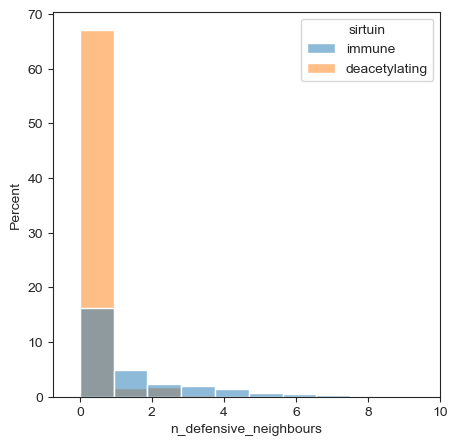

In [7]:
# Draw distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(data=n_df_in_context, x="n_defensive_neighbours", hue="sirtuin", ax=ax, stat="percent")
ax.set_xlim(xmax=10)

do_save = False
if do_save:
    plt.savefig("C:/Users/hvays/These/projects/fam/manuscript/supplementary_figures/Supp_Fig_Defensive_Context/data/n_ds_nearby_group=both.svg")

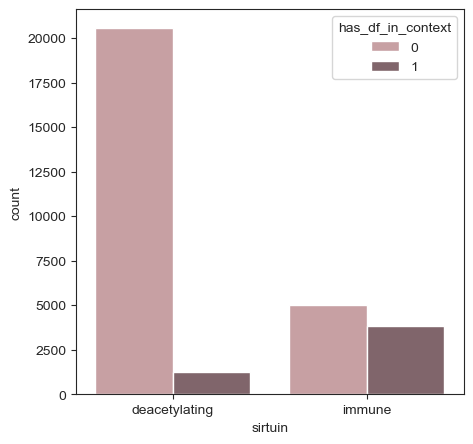

In [60]:
# Draw distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sir_palette = {0: '#ce999d', 1: '#856069'}
sns.barplot(data=n_df_in_context.value_counts(["sirtuin", "has_df_in_context"]).reset_index(), x="sirtuin", y="count", hue="has_df_in_context", ax=ax, palette=sir_palette)

do_save = False
if do_save:
    plt.savefig("C:/Users/hvays/These/projects/fam/manuscript/supplementary_figures/Supp_Fig_Defensive_Context/data/has_ds_nearby_group=both.svg")

In [10]:
# Test for enrichment of presence/absence of defense systems in the genomic context 
from scipy.stats import fisher_exact, chi2_contingency
import statsmodels.api as sm

contingency_table = n_df_in_context.value_counts(["sirtuin", "has_df_in_context"]).reset_index().pivot(index="sirtuin", columns="has_df_in_context", values="count")

res, p = fisher_exact(contingency_table, alternative="two-sided")

t22 = sm.stats.Table2x2(contingency_table.values)

print("Fisher test (scipy.stats):")
print(res, f"{p:.5e}")

print("Fisher test (statsmodels)")
print(t22.summary())

Fisher test (scipy.stats):
12.398602848329888 0.00000e+00
Fisher test (statsmodels)
               Estimate   SE   LCB    UCB   p-value
---------------------------------------------------
Odds ratio       12.399       11.555 13.304   0.000
Log odds ratio    2.518 0.036  2.447  2.588   0.000
Risk ratio        1.665        1.635  1.697   0.000
Log risk ratio    0.510 0.009  0.492  0.529   0.000
---------------------------------------------------


In [13]:
import numpy as np
min_p_value = np.nextafter(0, 1)

print(min_p_value)

5e-324


In [8]:
from scipy.stats import mannwhitneyu

stat, pval = mannwhitneyu(n_df_in_context.loc[n_df_in_context["sirtuin"] == "deacetylating", "n_defensive_neighbours"], n_df_in_context.loc[n_df_in_context["sirtuin"] == "immune", "n_defensive_neighbours"])

print(stat, pval)

59795244.5 0.0


In [93]:
# Enrichment in defense systems in the genomic neighbourhood per gene in deacetylating vs. defensive sirtuins
n_sir2_n_sir2_like = n_df_in_context.groupby("sirtuin").size().reset_index().rename({0: "n_genes"}, axis=1)
sir2_vs_sir2_like = n_df_in_context.groupby("sirtuin").sum("has_df_in_context").reset_index().drop("neighbour_is_defensive", axis=1)
sir2_vs_sir2_like = pd.merge(n_sir2_n_sir2_like, sir2_vs_sir2_like, on="sirtuin")
sir2_vs_sir2_like["perc_df_in_context"] = (sir2_vs_sir2_like["has_df_in_context"] / sir2_vs_sir2_like["n_genes"]) * 100

do_save = False
if do_save:
    sir2_vs_sir2_like.to_csv("I:/fam/dev/fam118b/4_defense_systems/results/sir2_sir2-like_kingdom=bact-arch_defensive_context.counts", sep="\t", index=False)

sir2_vs_sir2_like

sirtuin  n_genes  has_df_in_context  perc_df_in_context
0  deacetylating    21856               1276            5.838214
1         immune     8826               3836           43.462497

In [168]:
g = n_df_in_context.value_counts(["sirtuin", "has_df_in_context"]).reset_index()

<Axes: xlabel='has_df_in_context'>

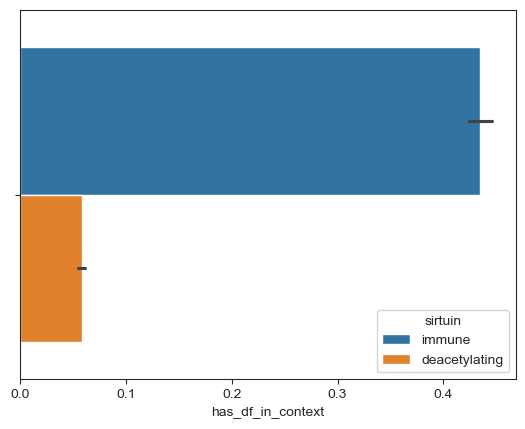

In [165]:
sns.bartplot(data=n_df_in_context, x="has_df_in_context", hue="sirtuin")

# Build iTol tables

### Build heatmap of %sequences which have a defensive context for each mmseqs cluster

In [133]:
bact_fam118b_mmseqs = pd.read_csv("I:/fam/dev/fam118b/1_detection/8_round_adl/results/1e-05_bs-gt-55_qcov-gt-60_len-200-2300/mmseqs/sir2_domain_80-80/fam118b_round-8-adl_kingdom=bact_1e-05_bs-gt-55_qcov-gt-60_len-200-2300_hit_region_50-80_cluster.tsv", header=None, sep="\t")
arch_fam118b_mmseqs = pd.read_csv("I:/fam/dev/fam118b/1_detection/8_round_adl/results/1e-05_bs-gt-55_qcov-gt-60_len-200-2300/mmseqs/sir2_domain/fam118b_round-8-adl_kingdom=arch_1e-05_bs-gt-55_qcov-gt-60_len-200-2300_hit_region_90-90_cluster.tsv", header=None, sep="\t")
pf14253_mmseqs = pd.read_csv("I:/fam/dev/abiH/results/1e-05_bs-gt-20_qcov-gt-60_len-100-2500/mmseqs/sir2_domain/pf14253_kingdom=all_1e-05_bs-gt-20_qcov-gt-60_len-100-2500_hit_region_50-80_cluster.tsv", sep="\t", header=None)
sirtuins_mmseqs = pd.read_csv("I:/fam/dev/sirtuins/detection/5_round_adl/results/1e-05_bs-gt-80_qcov-gt-60_len-100-2500/mmseqs/sir2_domain/sirtuins_round-5_kingdom=all_1e-05_bs-gt-80_qcov-gt-60_len-100-2500_hit_region_50-80_cluster.tsv", sep="\t", header=None)

bact_fam118b_mmseqs["sirtuin"] = "immune"
arch_fam118b_mmseqs["sirtuin"] = "immune"
pf14253_mmseqs["sirtuin"] = "immune"
sirtuins_mmseqs["sirtuin"] = "deacetylating"

all_seqs = pd.concat([bact_fam118b_mmseqs, arch_fam118b_mmseqs, pf14253_mmseqs, sirtuins_mmseqs], axis=0).rename({0: "rep_seq", 1: "gene"}, axis=1)
all_rep_seq = all_seqs.groupby("rep_seq").size().reset_index().rename({0: "n_seqs_in_cluster"}, axis=1)
n_df_in_cluster = pd.merge(n_df_in_context, all_seqs, on="gene").groupby("rep_seq").sum("has_df_in_context").reset_index().drop("neighbour_is_defensive", axis=1)
all_rep_seq = pd.merge(all_rep_seq, n_df_in_cluster, left_on="rep_seq", right_on="rep_seq")
all_rep_seq["perc_cluster_is_defensive"] = (all_rep_seq["has_df_in_context"] / all_rep_seq["n_seqs_in_cluster"]) * 100

do_save = True
if do_save:
    all_rep_seq[["rep_seq", "perc_cluster_is_defensive"]].to_csv("I:/fam/dev/fam118b/4_defense_systems/results/sir2_sir2-like_kingdom=bact-arch_rep_seq_perc_ds_in_cluster.tsv", sep="\t", index=False, header=False)

all_rep_seq

rep_seq  n_seqs_in_cluster  has_df_in_context  \
0     ABDE001.0722.00001.C001_01151                  1                  1   
1     ACAR001.0722.00001.C001_00799                  1                  0   
2     ACBA002.0722.00172.C001_01538                  2                  0   
3     ACBE001.0722.00002.C001_03506                  6                  6   
4     ACDE002.0722.00001.C001_02942                  1                  0   
...                             ...                ...                ...   
1854  YISP002.0722.00001.C001_06342                  2                  0   
1855  ZHFO001.0722.00001.C001_01838                  1                  0   
1856  ZOGA001.0722.00001.C001_04028                 26                 26   
1857  ZUPR001.0722.00001.C001_01247                  1                  0   
1858  ZYPA001.0722.00001.C001_00657                  4                  1   

      perc_cluster_is_defensive  
0                         100.0  
1                           0.0  
2                           0.0  
3                         100.0  
4                           0.0  
...                         ...  
1854                        0.0  
1855                        0.0  
1856                      100.0  
1857                        0.0  
1858                       25.0  

[1859 rows x 4 columns]

### Build table of defense systems for each mmseqs cluster

Defense systems directly involved in a defense system.

In [155]:
all_defense_systems = []
is_df = []
for i, row in all_seqs.iterrows():
    if row["gene"] in df_dict:
        is_df.append(df_dict[row["gene"]])
    else:
        is_df.append("NA")
all_seqs["defense_system_subfamily"] = is_df

all_seqs["defense_system"] = all_seqs["defense_system_subfamily"].apply(lambda x: x.split("__")[0]).replace({"Thoeris_I": "Thoeris", "Avs_V": "Avs", "Gao_Her_SIR": "Nezha", "Lamassu-Fam": "Lamassu", 
                                                                                                             "Avs_II": "Avs", "Septu": "Other", "RM_Type_IIG": "Other", "Thoeris_II": "Thoeris"})

all_ds = all_seqs.loc[all_seqs["defense_system"]  != "NA"]

all_ds

rep_seq  \
0                   BRSP008.0722.00001.C001_02168   
1                   BRSP008.0722.00001.C001_02168   
2                   BRSP008.0722.00001.C001_02168   
3                   BRSP008.0722.00001.C001_02168   
4                   BRSP008.0722.00001.C001_02168   
...                                           ...   
46636  GCA_002287475.2-Fun_CM008252.1_i000_002457   
46637  GCA_002287475.2-Fun_CM008252.1_i000_002457   
46638  GCA_002287475.2-Fun_CM008252.1_i000_002457   
46639  GCA_010015655.1-Fun_ML976814.1_i000_016493   
46640  GCA_010015655.1-Fun_ML976814.1_i000_016493   

                                                    gene        sirtuin  \
0                          BRSP008.0722.00001.C001_02168         immune   
1                          PABE003.0722.00001.C001_00609         immune   
2                          COSP011.0722.00001.C001_02611         immune   
3                          DESP028.0722.00001.C001_01857         immune   
4                          SPMA001.0722.00002.C001_01222         immune   
...                                                  ...            ...   
46636         GCA_002287475.2-Fun_CM008252.1_i000_002457  deacetylating   
46637         GCA_000827485.1-Fun_KN818295.1_i000_011193  deacetylating   
46638  GCA_015501595.1-Fun_JADNRX010000463.1_i000_019458  deacetylating   
46639         GCA_010015655.1-Fun_ML976814.1_i000_016493  deacetylating   
46640         GCA_010015655.1-Fun_ML976695.1_i000_009343  deacetylating   

      defense_system defense_system_subfamily  
0               pAgo           pAgo__SIR2APAZ  
1               pAgo           pAgo__SIR2APAZ  
2               pAgo           pAgo__SIR2APAZ  
3               pAgo           pAgo__SIR2APAZ  
4               pAgo           pAgo__SIR2APAZ  
...              ...                      ...  
46636             NA                       NA  
46637             NA                       NA  
46638             NA                       NA  
46639             NA                       NA  
46640             NA                       NA  

[55179 rows x 5 columns]

In [162]:
all_ds[["rep_seq", "defense_system"]].to_csv("I:/fam/dev/fam118b/4_defense_systems/results/sir2-like_rep_seq_with_ds.tsv", sep="\t", index=False)